### Machine Lerning Course - Final Project
#### Lior Ben Ari

#### All imports

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import requests
from tqdm import tqdm
import shutil
import gzip

#### Parameters (Etid it as needed)

In [2]:
''' 
Set to True at first run. 
It will download the dataset and filter it to include only
samples with Vis-NIR data and target.
'''
is_first_run = False 

#### Download OSSL Dataset (if required)
Link for website: https://docs.soilspectroscopy.org/index.html#ossl-mongodb

In [3]:
if is_first_run:
    url = "https://storage.googleapis.com/soilspec4gg-public/ossl_all_L0_v1.2.csv.gz"
    response = requests.get(url, stream=True)

    # Download data
    with open("ossl_all_L0_v1.2.csv.gz", "wb") as handle:
        for data in tqdm(response.iter_content(chunk_size=8192)):
            handle.write(data)

    # Unzip file
    with gzip.open("ossl_all_L0_v1.2.csv.gz", "rb") as f_in:
        with open("ossl_all_L0_v1.2.csv", "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    print("Download Completed")


##### Read full dataset. Filter to include samples that have both Vis-NIR and target data.

In [4]:
visnir_cols = ["scan_visnir.450_ref" , "scan_visnir.2450_ref"]
target_col = "clay.tot_iso.11277_w.pct"

if is_first_run:
    # Read entire database
    full_dataset_df = pd.read_csv("ossl_all_L0_v1.2.csv")
    
    # filter by Vis-NIR existance:
    visnir_dataset_df = full_dataset_df.loc[full_dataset_df.loc[:, visnir_cols[0]:visnir_cols[1]].notna().all(axis=1)]

    # filter by target existance:
    visnir_traget_dataset_df = visnir_dataset_df[visnir_dataset_df[target_col].notna()]

    # keep the filter dataset in a separated file
    visnir_traget_dataset_df.to_csv("Datasets/OSSL_db_filtered.csv")

##### Helpers (functions):

In [5]:
def show_spectroscopies(x, spectras, train_or_test):
    plt.figure()
    graphs_to_show = range(0, len(spectras), round(len(spectras)/5))
    for graph in graphs_to_show:
        sns.lineplot(x=x, y=spectras[graph])
    plt.xlabel("wavelength nm")
    plt.ylabel("reflectance")
    plt.title("5 different spectroscopies " + train_or_test)
    plt.grid(True)


def gen_parityplot(targets, preds, model_name):
    plt.figure()
    min_val = min(min(targets), min(preds))
    max_val = max(max(targets), max(preds))
    ax = sns.scatterplot(x=preds, y=targets)
    x = [min_val, max_val]
    y = [min_val, max_val]
    plt.plot(x,y, color='red')
    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    plt.title(f"{model_name} Parity Plot")
    ax.set_facecolor("lavender")

##### Machine Learning Functions. I will use this functions later.

XGBoost:

In [6]:
def XGBoost_Model(train_X, train_y, test_X, test_y): 
    xgboost_model = HistGradientBoostingRegressor()
    
    param_grid = {
        'max_iter': [100,200,300],
        'max_depth': [2,4,6],
        'learning_rate': [0.1,0.2,0.3]
    }

    xgboost_grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
    xgboost_grid_search.fit(train_X, train_y)

    best_xgboost_model = xgboost_grid_search.best_estimator_
    best_xgboost_model.fit(train_X, train_y)

    validation_prediction = best_xgboost_model.predict(test_X)

    rmse = root_mean_squared_error(y_true=test_y, y_pred=validation_prediction)
    r_squared_predicion = r2_score(y_true=test_y, y_pred=validation_prediction)
    r_squared_grid_search = xgboost_grid_search.best_score_
    best_params = xgboost_grid_search.best_params_

    return validation_prediction, rmse, r_squared_predicion, r_squared_grid_search, best_params

Random Forest:

In [7]:
def Random_Forest_Model(train_X, train_y, test_X, test_y): 
    rf_model = RandomForestRegressor(n_estimators=500)
    
    param_grid = {
        'max_features': range(2, 22, 2)
    }

    rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
    rf_grid_search.fit(train_X, train_y)

    best_rf_model = rf_grid_search.best_estimator_
    best_rf_model.fit(train_X, train_y)

    validation_prediction = best_rf_model.predict(test_X)

    rmse = root_mean_squared_error(y_true=test_y, y_pred=validation_prediction)
    r_squared_predicion = r2_score(y_true=test_y, y_pred=validation_prediction)
    r_squared_grid_search = rf_grid_search.best_score_
    best_params = rf_grid_search.best_params_

    return validation_prediction, rmse, r_squared_predicion, r_squared_grid_search, best_params

PLSR

In [8]:
def PLSR_Model(train_X, train_y, test_X, test_y):
    plsr_model = PLSRegression()
    # PLSR hyperparameters dict:
    plsr_param_grid = {
        'n_components': range(2, 32, 2)
    }
    plsr_grid_search = GridSearchCV(estimator=plsr_model, param_grid=plsr_param_grid, cv=5, scoring='r2', n_jobs=-1)
    plsr_grid_search.fit(train_X, train_y)

    best_plsr_model = plsr_grid_search.best_estimator_
    best_plsr_model.fit(train_X, train_y)

    validation_prediction = best_plsr_model.predict(test_X)

    rmse = root_mean_squared_error(y_true=test_y, y_pred=validation_prediction)
    r_squared_predicion = r2_score(y_true=test_y, y_pred=validation_prediction)
    r_squared_grid_search = plsr_grid_search.best_score_
    best_params = plsr_grid_search.best_params_

    return validation_prediction, rmse, r_squared_predicion, r_squared_grid_search, best_params

Prediction function with all models:

In [9]:
def predict_with_all_models(train_X, train_y, test_X, test_y):
    # XGBoost:
    test_pred, rmse, r2_predicion, r2_grid_search, best_params = XGBoost_Model(train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)
    print("xxxxxxx XGBoost Results: xxxxxxx")
    print(f"RMSE: {round(rmse,3)}")
    print(f"r2 test: {round(r2_predicion,3)}")
    print(f"r2 cv: {round(r2_grid_search,3)}")
    print(f"best params: {best_params}")
    print()
    gen_parityplot(test_y, test_pred, model_name="XGBoost")

    # Random Forest:
    test_pred, rmse, r2_predicion, r2_grid_search, best_params = Random_Forest_Model(train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)
    print("xxxxxxx Random Forest Results: xxxxxxx")
    print(f"RMSE: {round(rmse,3)}")
    print(f"r2 test: {round(r2_predicion,3)}")
    print(f"r2 cv: {round(r2_grid_search,3)}")
    print(f"best params: {best_params}")
    print()
    gen_parityplot(test_y, test_pred, model_name="Random Forest")

    # PLSR:
    test_pred, rmse, r2_predicion, r2_grid_search, best_params = PLSR_Model(train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)
    print("xxxxxxx PLSR Results: xxxxxxx")
    print(f"RMSE: {round(rmse,3)}")
    print(f"r2 test: {round(r2_predicion,3)}")
    print(f"r2 cv: {round(r2_grid_search,3)}")
    print(f"best params: {best_params}")
    print()
    gen_parityplot(test_y, test_pred, model_name="PLSR")

##### Read filtered dataframe

In [10]:
ossl_df = pd.read_csv("Datasets/OSSL_db_filtered.csv")


C:\Users\Lior Ben Ari\AppData\Local\Temp\ipykernel_4684\1588041593.py:1: DtypeWarning: Columns (112,113,114,115,116,118,119,120,121,122) have mixed types. Specify dtype option on import or set low_memory=False.
  ossl_df = pd.read_csv("Datasets/OSSL_db_filtered.csv")


##### Show target distribution

Number of samples: 23239
Target min: 0.0
Target max: 79.0
Target mean: 18.058
Target median: 16.0
Target std: 12.936


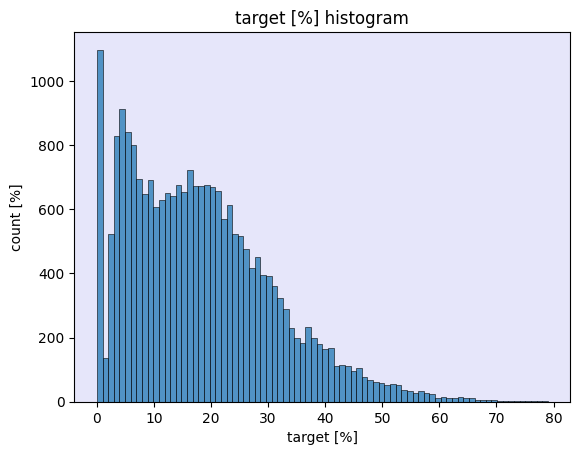

In [11]:
plt.figure()
ax = sns.histplot(data=ossl_df[target_col], bins=80)
plt.title("target [%] histogram")
plt.xlabel("target [%]", fontsize=10)
plt.ylabel("count [%]", fontsize=10)
ax.set_facecolor("lavender")

print(f"Number of samples: {len(ossl_df)}")
print(f"Target min: {round(ossl_df[target_col].min(), 3)}")
print(f"Target max: {round(ossl_df[target_col].max(), 3)}")
print(f"Target mean: {round(ossl_df[target_col].mean(), 3)}")
print(f"Target median: {round(ossl_df[target_col].median(), 3)}")
print(f"Target std: {round(ossl_df[target_col].std(), 3)}")

##### Split database to train and test samples. Show target's histogram for both train and test sets

################################
Train and Test sets target stats
################################
------------ Train Set --------------
Number of samples: 17429
Target min: 0.0
Target max: 79.0
Target mean: 18.053
Target median: 16.0
Target std: 12.882
------------ Test Set --------------
Number of samples: 5810
Target min: 0.0
Target max: 78.0
Target mean: 18.074
Target median: 16.0
Target std: 13.099


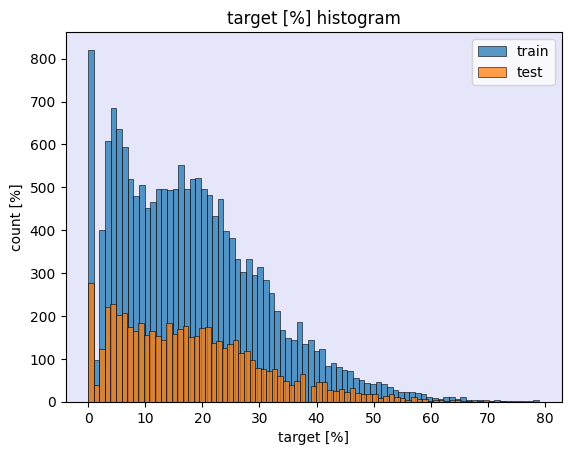

In [12]:
train_df, test_df = train_test_split(ossl_df, test_size=0.25, shuffle=True, random_state=42)
ax = sns.histplot(data=train_df[target_col], label="train", bins=80)
ax = sns.histplot(data=test_df[target_col], label="test", bins=80)
plt.title("target [%] histogram")
plt.xlabel("target [%]", fontsize=10)
plt.ylabel("count [%]", fontsize=10)
plt.legend()
ax.set_facecolor("lavender")

print("################################")
print("Train and Test sets target stats")
print("################################")

print("------------ Train Set --------------")
print(f"Number of samples: {len(train_df)}")
print(f"Target min: {round(train_df[target_col].min(), 3)}")
print(f"Target max: {round(train_df[target_col].max(), 3)}")
print(f"Target mean: {round(train_df[target_col].mean(), 3)}")
print(f"Target median: {round(train_df[target_col].median(), 3)}")
print(f"Target std: {round(train_df[target_col].std(), 3)}")

print("------------ Test Set --------------")
print(f"Number of samples: {len(test_df)}")
print(f"Target min: {round(test_df[target_col].min(), 3)}")
print(f"Target max: {round(test_df[target_col].max(), 3)}")
print(f"Target mean: {round(test_df[target_col].mean(), 3)}")
print(f"Target median: {round(test_df[target_col].median(), 3)}")
print(f"Target std: {round(test_df[target_col].std(), 3)}")

##### Extract predictors (Vis-NIR) and target from database.

In [13]:
first_wl = 450
last_wl = 2450

first_wl_col_idx = list(ossl_df.columns).index(f"scan_visnir.{first_wl}_ref")
last_wl_col_idx = list(ossl_df.columns).index(f"scan_visnir.{last_wl}_ref")

train_spectroscopies = np.array(train_df.iloc[:, first_wl_col_idx:last_wl_col_idx+1], dtype=np.float64)
train_target = np.array(train_df[target_col], dtype=np.float64)

test_spectroscopies = np.array(test_df.iloc[:, first_wl_col_idx:last_wl_col_idx+1], dtype=np.float64)
test_target = np.array(test_df[target_col], dtype=np.float64)

##### Prediction with reflectance spectra

Process data:

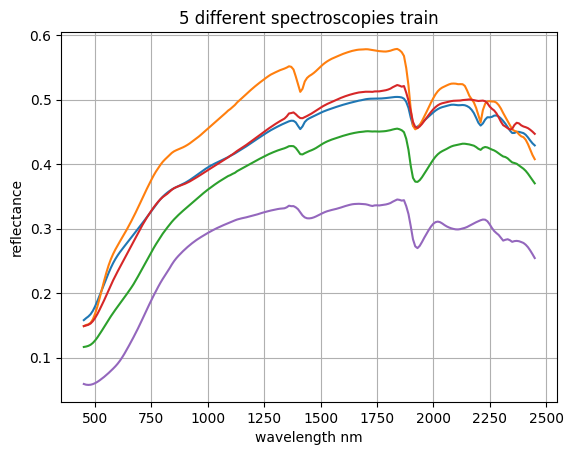

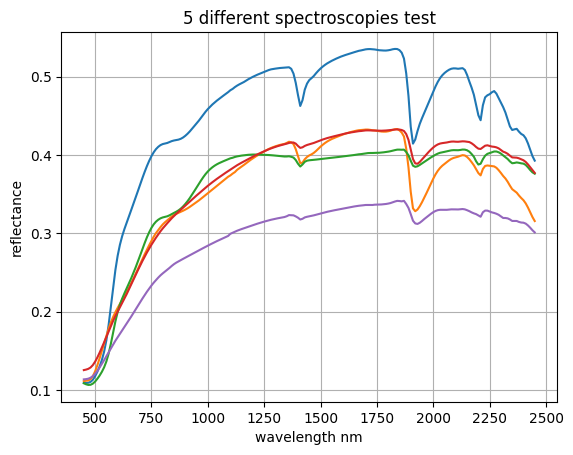

In [14]:
# Keep resolution of 10nm:
train_spectroscopies_10nm = [t[::5] for t in train_spectroscopies]
test_spectroscopies_10nm = [t[::5] for t in test_spectroscopies]

train_X = train_spectroscopies_10nm
train_y = train_target
test_X = test_spectroscopies_10nm
test_y = test_target

# Show different spectroscopies after SavGol smoothing:
x = np.arange(first_wl, last_wl+10, 10)
show_spectroscopies(x, train_X, "train")
show_spectroscopies(x, test_X, "test")

Predict:

xxxxxxx XGBoost Results: xxxxxxx
RMSE: 8.514
r2 test: 0.577
r2 cv: 0.573
best params: {'learning_rate': 0.1, 'max_depth': 6, 'max_iter': 300}

xxxxxxx Random Forest Results: xxxxxxx
RMSE: 8.713
r2 test: 0.558
r2 cv: 0.552
best params: {'max_features': 20}

xxxxxxx PLSR Results: xxxxxxx
RMSE: 7.587
r2 test: 0.664
r2 cv: 0.676
best params: {'n_components': 30}



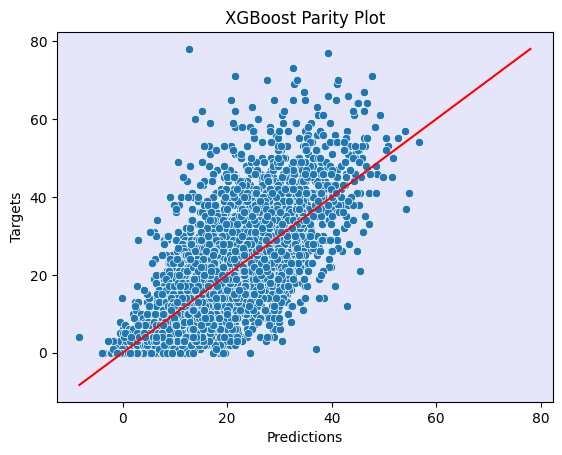

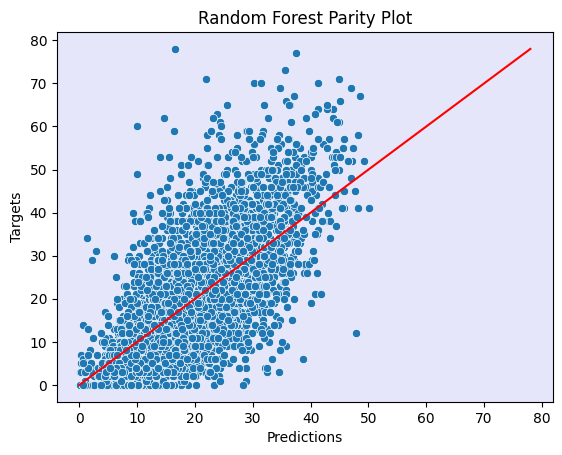

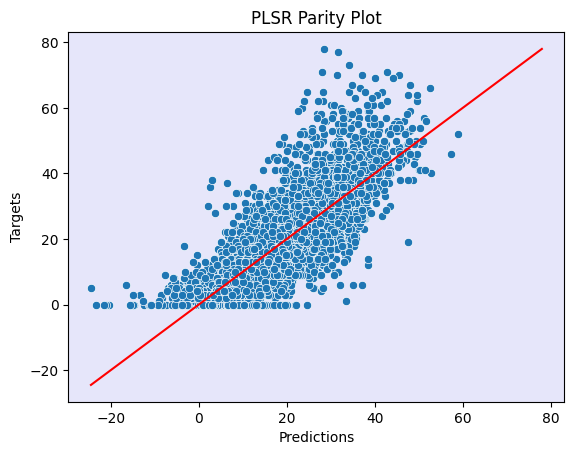

In [15]:
predict_with_all_models(train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)


##### Prediction with absorbance spectra:

Process data:

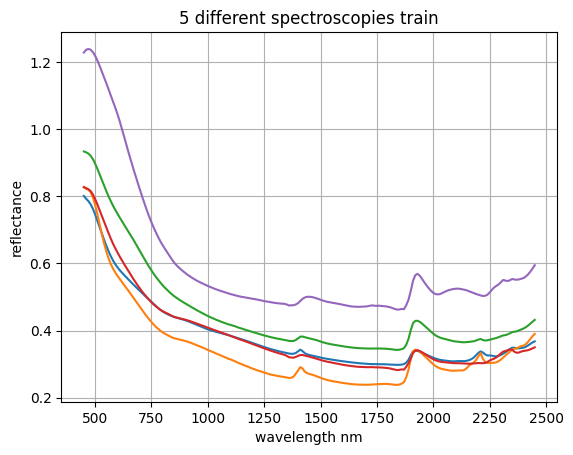

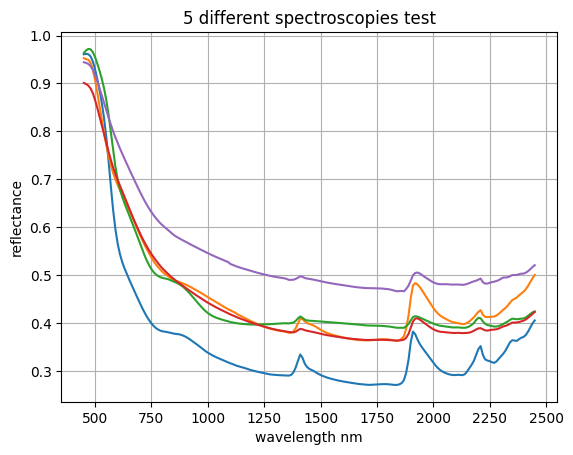

In [16]:
# Make sure there are not zeros so I can convert to absorbance
train_reflectance = np.clip(train_spectroscopies,1e-6, 1.0)
test_reflectance = np.clip(test_spectroscopies,1e-6, 1.0)

train_spectroscopies_absorbance = -np.log10(train_reflectance)
test_spectroscopies_absorbance = -np.log10(test_reflectance)

# Keep resolution of 10nm:
train_spectroscopies_absorbance = [t[::5] for t in train_spectroscopies_absorbance]
test_spectroscopies_absorbance = [t[::5] for t in test_spectroscopies_absorbance]

train_X = train_spectroscopies_absorbance
train_y = train_target
test_X = test_spectroscopies_absorbance
test_y = test_target

# Show different spectroscopies after SavGol smoothing:
x = np.arange(first_wl, last_wl+10, 10)
show_spectroscopies(x, train_X, "train")
show_spectroscopies(x, test_X, "test")

Predict:

xxxxxxx XGBoost Results: xxxxxxx
RMSE: 8.619
r2 test: 0.567
r2 cv: 0.567
best params: {'learning_rate': 0.1, 'max_depth': 6, 'max_iter': 200}

xxxxxxx Random Forest Results: xxxxxxx
RMSE: 8.706
r2 test: 0.558
r2 cv: 0.553
best params: {'max_features': 20}

xxxxxxx PLSR Results: xxxxxxx
RMSE: 7.406
r2 test: 0.68
r2 cv: 0.687
best params: {'n_components': 30}



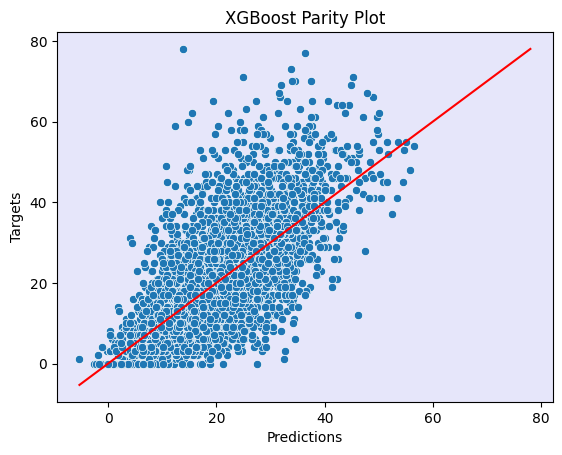

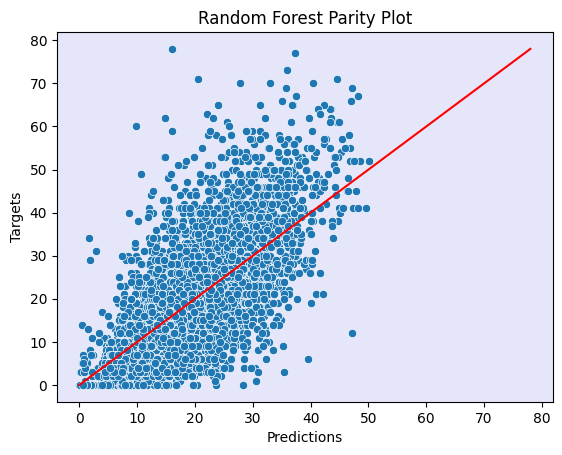

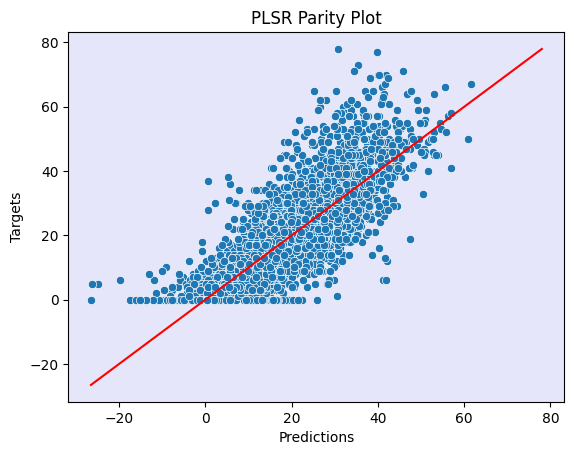

In [17]:
predict_with_all_models(train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)


##### Prediction with SavGol filtering smoothing

Process data:

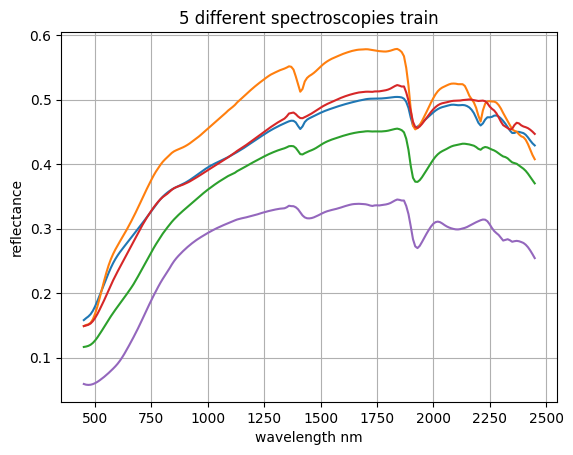

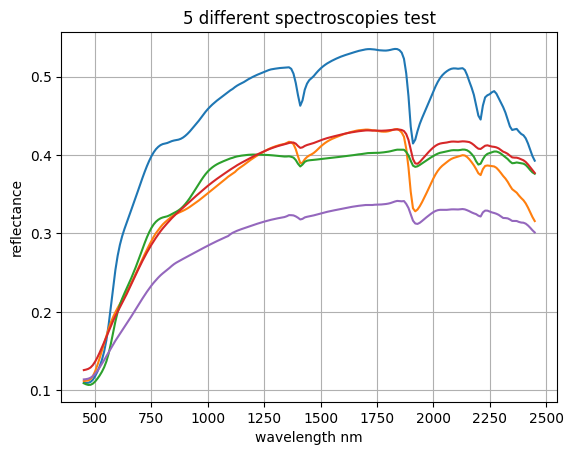

In [18]:
train_spectroscopies_savgol = savgol_filter(train_spectroscopies, window_length=11, polyorder=2)
test_spectroscopies_savgol = savgol_filter(test_spectroscopies, window_length=11, polyorder=2)

# Keep resolution of 10nm:
train_spectroscopies_savgol = [t[::5] for t in train_spectroscopies_savgol]
test_spectroscopies_savgol = [t[::5] for t in test_spectroscopies_savgol]

train_X = train_spectroscopies_savgol
train_y = train_target
test_X = test_spectroscopies_savgol
test_y = test_target

# Show different spectroscopies after SavGol smoothing:
x = np.arange(first_wl, last_wl+10, 10)
show_spectroscopies(x, train_X, "train")
show_spectroscopies(x, test_X, "test")

Predict:

xxxxxxx XGBoost Results: xxxxxxx
RMSE: 8.516
r2 test: 0.577
r2 cv: 0.571
best params: {'learning_rate': 0.1, 'max_depth': 6, 'max_iter': 300}

xxxxxxx Random Forest Results: xxxxxxx
RMSE: 8.701
r2 test: 0.559
r2 cv: 0.553
best params: {'max_features': 20}

xxxxxxx PLSR Results: xxxxxxx
RMSE: 7.59
r2 test: 0.664
r2 cv: 0.675
best params: {'n_components': 30}



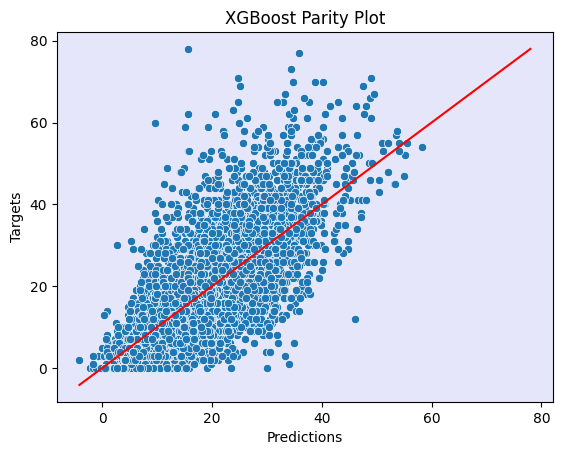

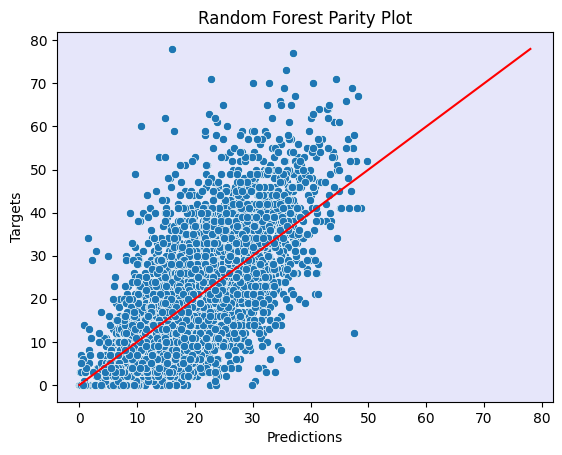

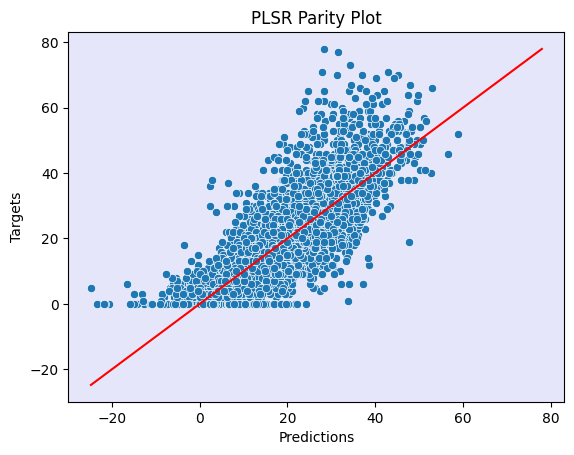

In [19]:
predict_with_all_models(train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)


##### Prediction with SavGol + 1st deriv

Process data:

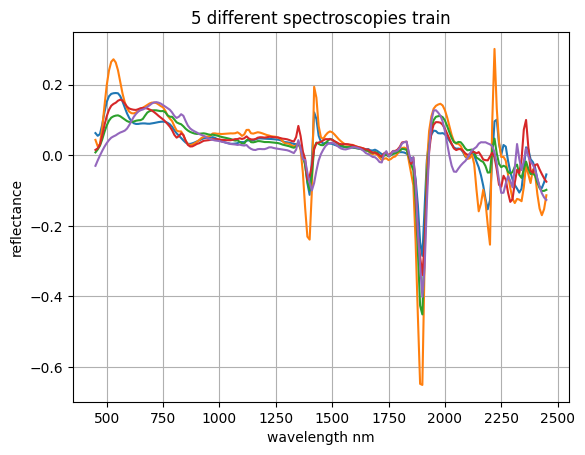

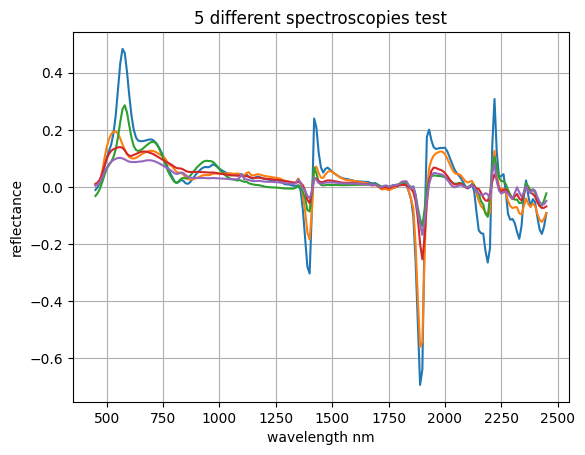

In [14]:
train_spectroscopies_savgol_deriv1 = savgol_filter(train_spectroscopies, window_length=11, polyorder=2, deriv=1)
test_spectroscopies_savgol_deriv1 = savgol_filter(test_spectroscopies, window_length=11, polyorder=2, deriv=1)

train_spectroscopies_savgol_deriv1 = train_spectroscopies_savgol_deriv1*100 
test_spectroscopies_savgol_deriv1 = test_spectroscopies_savgol_deriv1*100

# Keep resolution of 10nm:
train_spectroscopies_savgol_deriv1 = [t[::5] for t in train_spectroscopies_savgol_deriv1]
test_spectroscopies_savgol_deriv1 = [t[::5] for t in test_spectroscopies_savgol_deriv1]

train_X = train_spectroscopies_savgol_deriv1
train_y = train_target
test_X = test_spectroscopies_savgol_deriv1
test_y = test_target

# Show different spectroscopies after SavGol + 1st deriv:
x = np.arange(first_wl, last_wl+10, 10)
show_spectroscopies(x, train_X, "train")
show_spectroscopies(x, test_X, "test")


Predict:

xxxxxxx XGBoost Results: xxxxxxx
RMSE: 6.224
r2 test: 0.774
r2 cv: 0.767
best params: {'learning_rate': 0.1, 'max_depth': 6, 'max_iter': 300}

xxxxxxx Random Forest Results: xxxxxxx
RMSE: 7.043
r2 test: 0.711
r2 cv: 0.715
best params: {'max_features': 20}

xxxxxxx PLSR Results: xxxxxxx
RMSE: 7.395
r2 test: 0.681
r2 cv: 0.689
best params: {'n_components': 30}



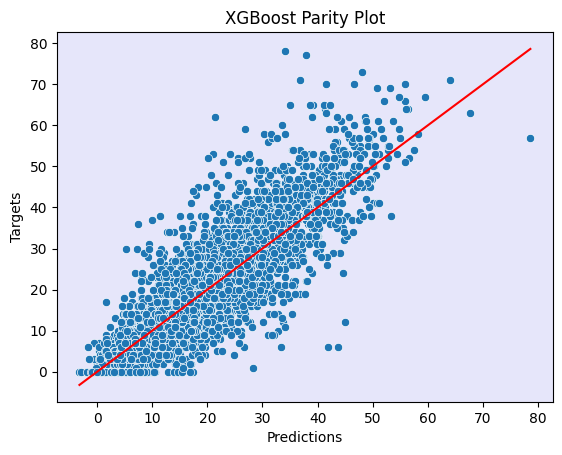

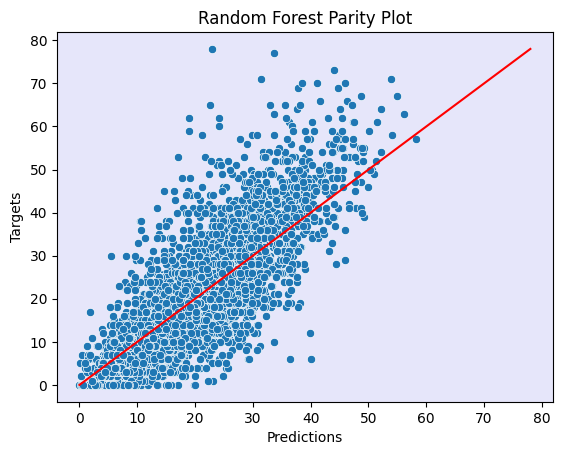

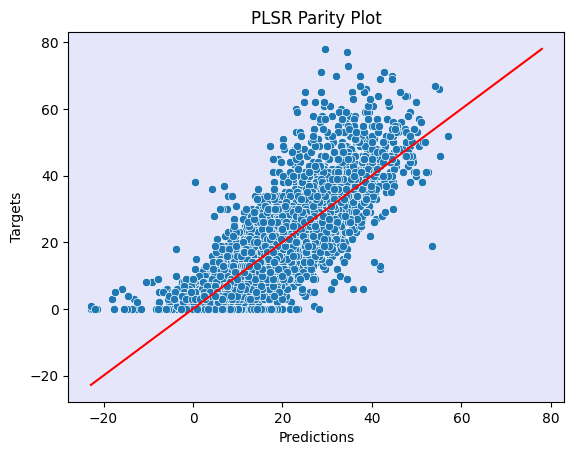

In [15]:
predict_with_all_models(train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)


##### Best R2 score was obtain by using XGBoost Model with SavGol and first derivation. Now, I will use this model and pre-processing method to predict with applying PCA and extracting the first 30 components. 

Applying PCA to the features

xxxxxxx XGBoost Results: xxxxxxx
RMSE: 6.284
r2 test: 0.77
r2 cv: 0.775
best params: {'learning_rate': 0.1, 'max_depth': 6, 'max_iter': 300}



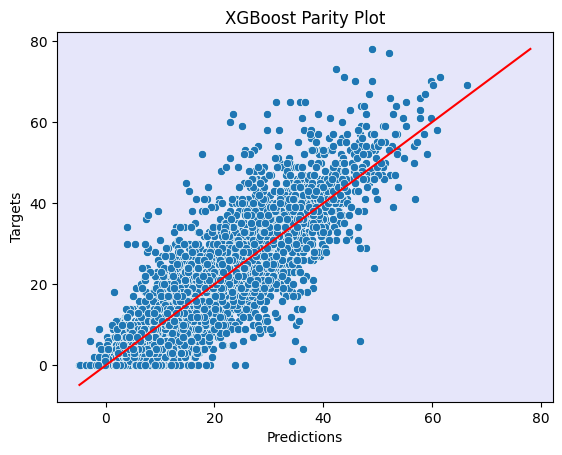

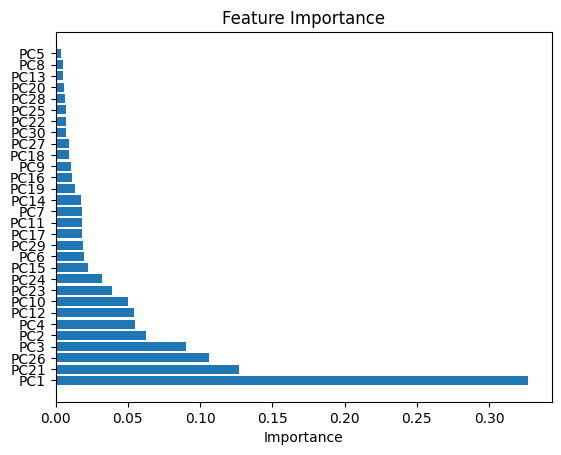

In [31]:
pca = PCA(n_components=30)

train_X = pca.fit_transform(train_spectroscopies_savgol_deriv1)
train_y = train_target
test_X = pca.transform(test_spectroscopies_savgol_deriv1)
test_y = test_target

xgboost_model = HistGradientBoostingRegressor()
    
param_grid = {
    'max_iter': [100,200,300],
    'max_depth': [2,4,6],
    'learning_rate': [0.1,0.2,0.3]
}

xgboost_grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
xgboost_grid_search.fit(train_X, train_y)

best_xgboost_model = xgboost_grid_search.best_estimator_
best_xgboost_model.fit(train_X, train_y)

validation_prediction = best_xgboost_model.predict(test_X)

rmse = root_mean_squared_error(y_true=test_y, y_pred=validation_prediction)
r_squared_predicion = r2_score(y_true=test_y, y_pred=validation_prediction)
r_squared_grid_search = xgboost_grid_search.best_score_
best_params = xgboost_grid_search.best_params_

print("xxxxxxx XGBoost Results: xxxxxxx")
print(f"RMSE: {round(rmse,3)}")
print(f"r2 test: {round(r_squared_predicion,3)}")
print(f"r2 cv: {round(r_squared_grid_search,3)}")
print(f"best params: {best_params}")
print()
gen_parityplot(test_y, validation_prediction, model_name="XGBoost")

feature_importances = permutation_importance(best_xgboost_model, test_X, test_y)
feature_names = [f"PC{i+1}" for i in range(train_X.shape[1])]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure()
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


##### From the results we see that using PCA and extracting first 30 components have barely any effect on the results.